From Rick:

1. Look at the FP data from a cancer type (agg stats for all cell Lines in a given cancer type), cell line, drug, and drug class perspectives.
2. Are some {studies, cell lines, drugs, drug class, cancer type} harder than others to predict correctly?
3. If we filter out samples with poor AUC fits do the predictions improve (they should but we should characterize the level of improvement).
4. Ideally we want to set some quality thresholds that can be applied to experimental results to improve training.
5. AUC fit is a good one --> (ap) Is this a question?
6. Test the suggested that we exclude the middle values from training (but not from validation) and see if that improves things.

Addressing requests:
1. False predictions from different perspectives. By: cancer type, cell line, drug, drug class.
   - (A) Parplots or boxplots of the most falsely predictable items (have similar plots)
2. Are some (studies, cell lines, drugs, drug class, cancer type) harder than others to predict correctly?
   - (NA) Directly falls from part (1)
3. If we drop samples with poor AUC fits, do the predictions improve? They should but we should characterize the level of improvement.
   - (A) Plot histogram of R2fit values  -->  DONE
   - (A) Plot of scores vs minimum R2fit in the dataset (requires to train multiple runs).  -->  DONE
     For each tick in R2fit specify the fraction of sample size as compared to the original dataset.
4. Ideally we want to set some quality thresholds that can be applied to experimental results to improve training.
   - (NA) Conclusion from part (3).
5. AUC fit is a good one --> (ap) Is this a question?
   - (?) None sure
6. Test the suggested that we exclude the middle values from training (but not from validation) and see if that improves things.
   - (A) Plot histogram of AUC values
   - (A) Plot histogram of AUC values for each of the following: FP, FN, TP, TN

In [1]:
!which python

/vol/ml/apartin/anaconda3/envs/p1/bin/python


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay  # error

In [3]:
# runs_dir_name = 'out_lgbm'
# runs_dir_name = 'out_lgbm_cls'
# runs_dir_name = 'out_lgbm_cls_811_v1'

# runs_dir_name = 'out_cls_r0'
# runs_dir_name = 'out_cls_r10'

runs_dir_name = 'rv_trains/trn_rv0.0'
# runs_dir_name = 'rv_trains/trn_rv0.9'
# runs_dir_name = 'gap_trains/gap_0.5_0.7'

In [4]:
file_path = Path.cwd()
print(file_path)

# mltype = 'reg'
mltype = 'cls'

out_postproc_fpath = file_path/'..'/runs_dir_name/'post_proc'
os.makedirs(out_postproc_fpath, exist_ok=True)
print(out_postproc_fpath)

# out_figs = file_path / 'out_figs_cls'
# os.makedirs(out_figs, exist_ok=True)

runs_dir_path = Path(file_path / '..' / runs_dir_name)
runs_dirs = [Path(p) for p in glob(str(runs_dir_path/'run_*'))]
# pred = pd.read_csv(os.path.join(predsdir, 'dev_lgb_reg_preds.csv'))

/vol/ml/apartin/projects/DrugResponseViz/notebooks
/vol/ml/apartin/projects/DrugResponseViz/notebooks/../rv_trains/trn_rv0.0/post_proc


In [5]:
# Load cell metadata
cancer_types = pd.read_csv(file_path/'../data/combined_cancer_types', sep='\t', names=['CELL', 'CTYPE'])
print(cancer_types.shape)

# cmeta = pd.read_csv(file_path/'../data/combined_metadata_2018May.txt', sep='\t')
# print(cmeta.shape)

# dmeta = pd.read_csv(file_path/'../data/drug_info', sep='\t')
# print(dmeta.shape)

(14590, 2)


# Aggregate predictions from all runs (shuffles/splits)

In [6]:
def reorg_cols(df, col_first:str):
    """
    Args:
        col_first : col name to put first
    """
    cols = df.columns.tolist()
    cols.remove(col_first)
    return df[[col_first] + cols]
    
def agg_preds_from_cls_runs(runs_dirs, phase='_te.csv', verbose=False):
    """ Aggregate predictions bootstraped ML trainings. """
    prd = []
    for i, dir_name in enumerate(runs_dirs):
        if '_tr.csv' in phase:
            prd_ = pd.read_csv(dir_name/'preds_tr.csv')
        elif '_vl.csv' in phase:
            prd_ = pd.read_csv(dir_name/'preds_vl.csv')
        elif '_te.csv' in phase:
            prd_ = pd.read_csv(dir_name/'preds_te.csv')
        
        # prd_te_['err'] = abs(prd_te_['y_true'] - prd_te_['y_pred'])      # add col 'err'
        prd_['run'] = str(dir_name).split(os.sep)[-1].split('_')[-1]  # add col 'run' identifier
        prd.append(prd_)  # append run data

        if verbose:
            if i%20==0:
                print(f'Processing {dir_name}')
            
    # Aggregate to df
    prd = pd.concat(prd, axis=0)
    
    # Reorganize cols
    prd = reorg_cols(prd, col_first='run').sort_values('run').reset_index(drop=True).reset_index().rename(columns={'index': 'idx'})
    return prd

In [7]:
# Concat preds from all runs      
prd_te_all = agg_preds_from_cls_runs(runs_dirs, phase='_te.csv')

# Add SOURCE column
if 'source' not in [str(i).lower() for i in prd_te_all.columns.to_list()]: 
    print('Add the SOURCE column.')
    prd_te_all.insert(loc=2, column='SOURCE', value=[s.split('.')[0].lower() for s in prd_te_all['CELL']])

# Add CTYPE column
prd_te_all = pd.merge(prd_te_all, cancer_types, on='CELL')
prd_te_all = reorg_cols(prd_te_all, col_first='CTYPE')

# Rename
prd_te_all = prd_te_all.rename(columns={'y_true': 'y_true_cls', 'y_pred': 'y_pred_prob'})

# Retain specific columns
cols = ['idx', 'run', 'SOURCE', 'CTYPE', 'CELL', 'DRUG', 'R2fit', 'AUC', 'y_true_cls', 'y_pred_prob']
prd_te_all = prd_te_all[cols]

# Add col of pred labels
prd_te_all['y_pred_cls'] = prd_te_all.y_pred_prob.map(lambda x: 0 if x<0.5 else 1)

# The highest error is 0.5 while the lowest is 0.
# This value is proportional to the square root of Brier score.
prd_te_all['prob_err'] = abs(prd_te_all.y_true_cls - prd_te_all.y_pred_prob)

# Bin AUC values
bins = np.arange(0, 1.1, 0.1).tolist()
prd_te_all['AUC_bin'] = pd.cut(prd_te_all.AUC, bins, right=True, labels=None, retbins=False,
                               precision=3, include_lowest=False, duplicates='raise')

# Add col that cetegorizes the preds
prd_te_all['prd_cat'] = None
prd_te_all.prd_cat[ (prd_te_all.y_true_cls==1) & (prd_te_all.y_pred_cls==1) ] = 'TP'
prd_te_all.prd_cat[ (prd_te_all.y_true_cls==0) & (prd_te_all.y_pred_cls==0) ] = 'TN'
prd_te_all.prd_cat[ (prd_te_all.y_true_cls==1) & (prd_te_all.y_pred_cls==0) ] = 'FN'
prd_te_all.prd_cat[ (prd_te_all.y_true_cls==0) & (prd_te_all.y_pred_cls==1) ] = 'FP'

# Add cols
prd_te_all['TP'] = prd_te_all.prd_cat=='TP'
prd_te_all['TN'] = prd_te_all.prd_cat=='TN'
prd_te_all['FP'] = prd_te_all.prd_cat=='FP'
prd_te_all['FN'] = prd_te_all.prd_cat=='FN'

print(prd_te_all.shape)
display( prd_te_all[:2] )

(3278200, 18)


,idx,run,SOURCE,CTYPE,CELL,DRUG,R2fit,AUC,y_true_cls,y_pred_prob,y_pred_cls,prob_err,AUC_bin,prd_cat,TP,TN,FP,FN
0,0,s000,CTRP,Colon_Adenocarcinoma,CTRP.OUMS-23,CTRP.413,0.9884,0.3739,1,0.498734,0,0.501266,"(0.3, 0.4]",FN,False,False,False,True
1,1507,s000,CTRP,Colon_Adenocarcinoma,CTRP.OUMS-23,CTRP.418,0.9925,0.9797,0,0.000226,0,0.000226,"(0.9, 1.0]",TN,False,True,False,False


In [8]:
# Plot confusion matrix
y_true_cls = prd_te_all.y_true_cls
y_pred_cls = prd_te_all.y_pred_cls

np_conf = confusion_matrix(y_true_cls, y_pred_cls)
tn, fp, fn, tp = confusion_matrix(y_true_cls, y_pred_cls).ravel()

mcc = sklearn.metrics.matthews_corrcoef(y_true_cls, y_pred_cls, sample_weight=None)
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)
print('FPR:', fp/(fp+tn))
print('FNR:', fn/(fn+tp))
print('MCC:', mcc)

with open(out_postproc_fpath/'scores.txt', 'w') as f:
    f.write('TN: {:d}\n'.format(tn))
    f.write('TN: {:d}\n'.format(tn))
    f.write('FP: {:d}\n'.format(fp))
    f.write('FN: {:d}\n'.format(fn))
    f.write('TP: {:d}\n'.format(tp))
    f.write('FPR: {:.5f}\n'.format(fp/(fp+tn)))
    f.write('FNR: {:.5f}\n'.format(fn/(fn+tp)))
    f.write('MCC: {:.5f}\n'.format(mcc))

TN: 3127700
FP: 23354
FN: 62107
TP: 65039
FPR: 0.007411488346439001
FNR: 0.4884699479338713
MCC: 0.6009257633005854


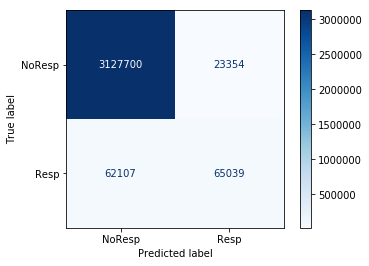

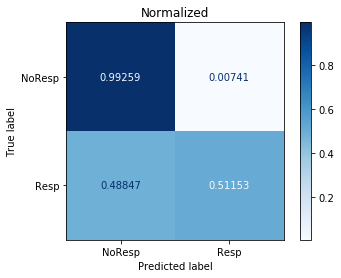

In [9]:
y_true_cls = prd_te_all.y_true_cls
y_pred_cls = prd_te_all.y_pred_cls

# Confusion Matrix
conf = confusion_matrix(y_true_cls, y_pred_cls, normalize=None)
conf_plot = ConfusionMatrixDisplay(conf, display_labels=['NoResp', 'Resp'])
conf_plot.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation=None, values_format='d')

# Confusion Matrix (normalized)
conf = confusion_matrix(y_true_cls, y_pred_cls, normalize='true')
conf_plot = ConfusionMatrixDisplay(conf, display_labels=['NoResp', 'Resp'])
conf_plot.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation=None, values_format='.5f')
conf_plot.ax_.set_title('Normalized');

# Brier Scores

In [10]:
# df_brier = prd_te_all.copy()
# # df_brier['y_pred_cls'] = df_brier.y_pred.map(lambda x: 0 if x<0.5 else 1)
# display(df_brier[:2])

# tp_df = df_brier[(df_brier.y_true_cls==1) & (df_brier.y_pred_cls==1)]
# fn_df = df_brier[(df_brier.y_true_cls==1) & (df_brier.y_pred_cls==0)]
# tn_df = df_brier[(df_brier.y_true_cls==0) & (df_brier.y_pred_cls==0)]
# fp_df = df_brier[(df_brier.y_true_cls==0) & (df_brier.y_pred_cls==1)]

# brier_scores = {}
# brier_scores['tp'] = sklearn.metrics.brier_score_loss(tp_df.y_true_cls, tp_df.y_pred_prob)
# brier_scores['fn'] = sklearn.metrics.brier_score_loss(fn_df.y_true_cls, fn_df.y_pred_prob)
# brier_scores['tn'] = sklearn.metrics.brier_score_loss(tn_df.y_true_cls, tn_df.y_pred_prob)
# brier_scores['fp'] = sklearn.metrics.brier_score_loss(fp_df.y_true_cls, fp_df.y_pred_prob)

# print(brier_scores)
# del df_brier

# Calibrate classification probabilities

- https://gdmarmerola.github.io/probability-calibration/
- https://github.com/Microsoft/LightGBM/issues/1562
- https://stats.stackexchange.com/questions/263393/scikit-correct-way-to-calibrate-classifiers-with-calibratedclassifiercv/263411
- https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV

# Summary Table (hard labels)

In [11]:
def barplot_high_low_items_by_mcc(labels, values, N=4, xlabel=None, figsize=(9, 7)):
    """ Plot the highest N and lowest N items. """
    fig, ax = plt.subplots(figsize=figsize)

    pos = np.arange(len(labels))

    rects1 = ax.barh(pos[:N], values[:N],
                     align='center', height=0.7,
                     color='b', edgecolor='k', alpha=0.6,
                     label='Highest Values')

    rects2 = ax.barh(pos[N:], values[N:],
                     align='center', height=0.7,
                     color='r', edgecolor='k', alpha=0.6,
                     label='Lowest Values')

    ylabels = [' '.join(s.split('_')) for s in labels]
    ax.set_yticks( pos )
    ax.set_yticklabels( ylabels )
    ax.set_xlabel(xlabel)
    ax.legend();

    for rect in rects1:
        width = rect.get_width()
        width = np.around(width, decimals=2)
        align = 'left'

        xloc = -40
        yloc = rect.get_y() + rect.get_height() / 2  # Center the text vertically in the bar
        label = ax.annotate(width,
                            xy=(width, yloc),
                            xytext=(xloc, 0),           # The position (x,y) to place the text at. If None, defaults to xy.
                            textcoords='offset points', # The coordinate system that xytext is given in
                            ha=align, va='center',
                            color='k', weight='bold', clip_on=True);

    for rect in rects2:
        width = rect.get_width()
        width = np.around(width, decimals=2)
        align = 'left'

        xloc = -50
        yloc = rect.get_y() + rect.get_height() / 2  # Center the text vertically in the bar
        label = ax.annotate(width,
                            xy=(width, yloc),
                            xytext=(xloc, 0),           # The position (x,y) to place the text at. If None, defaults to xy.
                            textcoords='offset points', # The coordinate system that xytext is given in
                            ha=align, va='center',
                            color='k', weight='bold', clip_on=True);
    return fig, ax

In [12]:
def add_meta(df):
    # Add N and P columns
    df['N'] = df.TN + df.FP
    df['P'] = df.TP + df.FN

    # Add TPR, TNR, FPR, FNR
    df['TPR'] = df.apply(lambda row: np.nan if (row.TP==0) & (row.FN==0) else row.TP / (row.TP + row.FN), axis=1)  # sensitivity, recall: TP/P = TP/(TP+FN)
    df['TNR'] = df.apply(lambda row: np.nan if (row.TN==0) & (row.FP==0) else row.TN / (row.TN + row.FP), axis=1)  # specificity: TN/N = TN/(TN+FP)
    df['FPR'] = df.apply(lambda row: np.nan if (row.TN==0) & (row.FP==0) else row.FP / (row.TN + row.FP), axis=1)  # fall-out: FP/N = FP/(FP+TN)
    df['FNR'] = df.apply(lambda row: np.nan if (row.TP==0) & (row.FN==0) else row.FN / (row.TP + row.FN), axis=1)  # miss-rate: FN/NP = FN/(FN+TP)

    # Add MCC
    def mcc_num(TP, TN, FP, FN):  return TP*TN - FP*FN
    def mcc_den(TP, TN, FP, FN):  return ( (TP+FP) * (TP+FN) * (TN+FP) * (TN+FN) ) ** (1/2)

    df['mcc_num'] = df.apply( lambda r: mcc_num(r.TP, r.TN, r.FP, r.FN), axis=1 )
    df['mcc_den'] = df.apply( lambda r: mcc_den(r.TP, r.TN, r.FP, r.FN), axis=1 )
    df['mcc'] = df.apply(lambda r: r.mcc_num/r.mcc_den if r.mcc_den>0.0001 else np.nan, axis=1)
    
    return df

In [13]:
# Cell hard scores
sm_cell_hard = prd_te_all.groupby('CELL').agg({
    'SOURCE': 'unique',
    'DRUG': 'unique',
    'CTYPE': lambda x: np.unique(x)[0],
    'TP': lambda x: int(sum(x)),
    'TN': lambda x: int(sum(x)),
    'FP': lambda x: int(sum(x)),
    'FN': lambda x: int(sum(x))
}).reset_index()
sm_cell_hard = add_meta(sm_cell_hard)

In [14]:
# Drug hard scores
sm_drug_hard = prd_te_all.groupby('DRUG').agg({
    'SOURCE': 'unique',    
    'CELL': 'unique',
    'CTYPE': lambda x: np.unique(x)[0],
    'TP': lambda x: int(sum(x)),
    'TN': lambda x: int(sum(x)),
    'FP': lambda x: int(sum(x)),
    'FN': lambda x: int(sum(x))
}).reset_index()
sm_drug_hard = add_meta(sm_drug_hard)

In [15]:
# Ctype hard scores
sm_ctype_hard = prd_te_all.groupby('CTYPE').agg({
    'SOURCE': 'unique',    
    'CELL': 'unique',
    'DRUG': 'unique',
    'TP': lambda x: int(sum(x)),
    'TN': lambda x: int(sum(x)),
    'FP': lambda x: int(sum(x)),
    'FN': lambda x: int(sum(x))
}).reset_index()
sm_ctype_hard = add_meta(sm_ctype_hard)

,CTYPE,SOURCE,CELL,DRUG,TP,TN,FP,FN,N,P,TPR,TNR,FPR,FNR,mcc_num,mcc_den,mcc
0,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,"[CTRP, GDSC, CCLE, gCSI]","[CTRP.SU-DHL-6, CTRP.OCI-LY3, CTRP.SU-DHL-8, G...","[CTRP.372, CTRP.528, CTRP.292, CTRP.389, CTRP....",6856,90301,1671,3106,91972,9962,0.688215,0.981831,0.018169,0.311785,613913530,8.542577e+08,0.718651
1,Lymphoid_Leukemia,"[CTRP, GDSC, CCLE, NCI60, gCSI]","[CTRP.697, CTRP.KMS-28BM, GDSC.KOPN-8, CTRP.SU...","[CTRP.35, CTRP.389, CTRP.170, CTRP.41, CTRP.98...",13198,229157,3914,6572,233071,19770,0.667577,0.983207,0.016793,0.332423,2998691278,4.311261e+09,0.695548


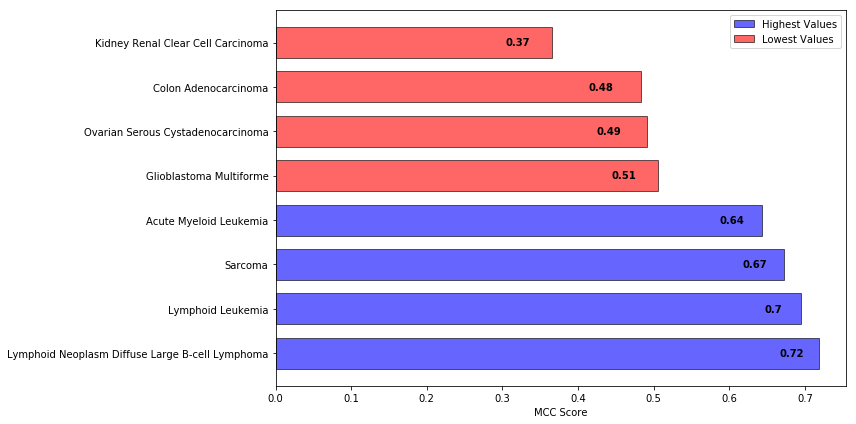

In [16]:
# Get the N most responsive cells
N = 4
col='mcc'
top_items = sm_ctype_hard.sort_values(col, ascending=True)[:N]   # Top items
bot_items = sm_ctype_hard.sort_values(col, ascending=True)[-N:]  # Bottom items
data_to_plot = pd.concat([top_items, bot_items], axis=0).sort_values(col, ascending=False).reset_index(drop=True)
display( data_to_plot[:2] )

# CTYPE
barplot_high_low_items_by_mcc(labels=data_to_plot.CTYPE.values,
                              values=data_to_plot[col].values,
                              xlabel=f'{col.upper()} Score', N=4, figsize=(12, 6));
plt.tight_layout()
plt.savefig(out_postproc_fpath/f'ctype_{col}_hist.png', dpi=150)

In [26]:
sm_ctype_hard.CTYPE.unique()

array(['Acute_Myeloid_Leukemia', 'Breast_Invasive_Carcinoma',
       'Colon_Adenocarcinoma', 'Esophageal_Carcinoma',
       'Glioblastoma_Multiforme', 'Head_and_Neck_Squamous_Cell_Carcinoma',
       'Kidney_Renal_Clear_Cell_Carcinoma',
       'Liver_Hepatocellular_Carcinoma', 'Lung_Adenocarcinoma',
       'Lung_Non-Small_Cell_Carcinoma', 'Lung_Small_Cell_Carcinoma',
       'Lung_Squamous_Cell_Carcinoma', 'Lymphoid_Leukemia',
       'Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma',
       'Ovarian_Serous_Cystadenocarcinoma', 'Ovary_NOS',
       'Pancreatic_Adenocarcinoma', 'Sarcoma', 'Skin_Cutaneous_Melanoma',
       'Stomach_Adenocarcinoma', 'Uterine_Corpus_Endometrial_Carcinoma'],
      dtype=object)

In [17]:
# # MCC is NaN.
# # The item completely determines the response (always response or non-response).
# cell_mcc_nan = sm_cell_hard[ sm_cell_hard.mcc.isna() ]
# cell_mcc_df = sm_cell_hard[ ~sm_cell_hard.mcc.isna() ]

# print('\nWorst by MCC ...')
# display( cell_mcc_df.sort_values('mcc', ascending=True)[:4] )
# print('\nBest by MCC ...')
# display( cell_mcc_df.sort_values('mcc', ascending=False)[:4] )
# print('\nMCC is NaN ...')
# display( cell_mcc_nan[:4] )

In [18]:
# # ... is NaN.
# # In certain cases there only one labels, and the classifier is consistent with predictions.
# display( sm_cell_hard.sort_values(['FPR', 'FNR'], ascending=[False, False])[:4] )
# display( sm_cell_hard.sort_values(['FNR', 'FPR'], ascending=[False, False])[:4] )

# Summary Table (soft labels)

In [19]:
def my_barplot(labels, values, xlabel=None, color='b', figsize=(7,5)):
    """ Simple barplot. """
    labels = labels
    values = values
    fig, ax = plt.subplots(figsize=figsize)
    rects = ax.barh(labels, values,
                    align='center', height=0.7,
                    color=color, edgecolor='k', alpha=0.6)

    pos = np.arange(len(labels))
    ylabels = [' '.join(s.split('_')) for s in labels]
    ax.set_yticks( pos )
    ax.set_yticklabels( ylabels )
    ax.set_xlabel(xlabel)

    for rect in rects:
        width = rect.get_width()
        width = np.around(width, decimals=2)
        align = 'left'

        xloc = -40
        yloc = rect.get_y() + rect.get_height() / 2  # Center the text vertically in the bar
        label = ax.annotate(width,
                            xy=(width, yloc),
                            xytext=(xloc, 0),           # The position (x,y) to place the text at. If None, defaults to xy.
                            textcoords='offset points', # The coordinate system that xytext is given in
                            ha=align, va='center',
                            color='k', weight='bold', clip_on=True);
    return fig, ax

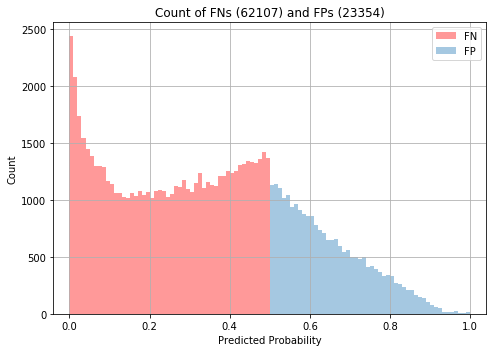

In [20]:
figsize=(7,5)
_, ax = plt.subplots(1,1,figsize=figsize)

fn_df = prd_te_all[prd_te_all.prd_cat=='FN']
fp_df = prd_te_all[prd_te_all.prd_cat=='FP']

ax = sns.distplot(fn_df.y_pred_prob, bins=50, kde=False, ax=ax, color='r', label='FN');
ax = sns.distplot(fp_df.y_pred_prob, bins=50, kde=False, ax=ax, label='FP');
ax.set_title('Count of FNs ({}) and FPs ({})'.format( fn_df.shape[0], fp_df.shape[0] ))
ax.set_ylabel('Count');
ax.set_xlabel('Predicted Probability');
ax.set_xlim(left=-0.04, right=1.04)
ax.grid(True)
ax.legend();

plt.tight_layout()
plt.savefig(out_postproc_fpath/'FNs_FPs_hist_all.png', dpi=150)

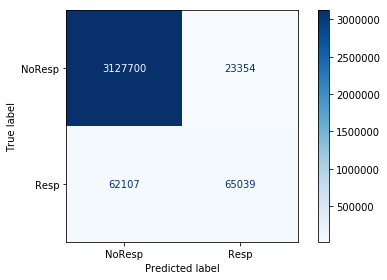

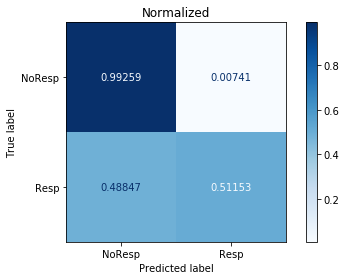

In [21]:
y_true_cls = prd_te_all.y_true_cls
y_pred_cls = prd_te_all.y_pred_cls

# Confusion Matrix
conf = confusion_matrix(y_true_cls, y_pred_cls, normalize=None)
conf_plot = ConfusionMatrixDisplay(conf, display_labels=['NoResp', 'Resp'])
conf_plot.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation=None, values_format='d')
plt.tight_layout()
plt.savefig(out_postproc_fpath/'conf_matrix_all.png', dpi=150)

# Confusion Matrix (normalized)
conf = confusion_matrix(y_true_cls, y_pred_cls, normalize='true')
conf_plot = ConfusionMatrixDisplay(conf, display_labels=['NoResp', 'Resp'])
conf_plot.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation=None, values_format='.5f')
conf_plot.ax_.set_title('Normalized');
plt.tight_layout()
plt.savefig(out_postproc_fpath/'conf_matrix_all_norm.png', dpi=150)

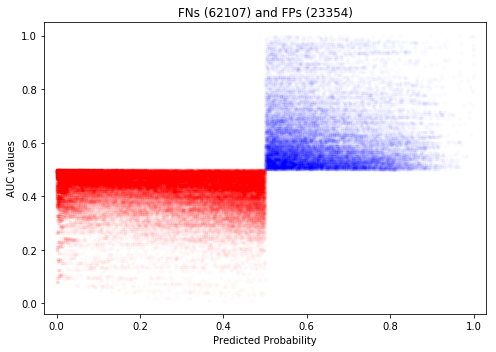

In [22]:
col = 'prd_cat'

figsize=(7,5)
_, ax = plt.subplots(1, 1, figsize=figsize)

fn_df = prd_te_all[prd_te_all[col]=='FN']
fp_df = prd_te_all[prd_te_all[col]=='FP']
ax.plot(fn_df.y_pred_prob, fn_df.AUC, '.', color='r', alpha=0.01, label='FN')
ax.plot(fp_df.y_pred_prob, fp_df.AUC, '.', color='b', alpha=0.01, label='FP')
ax.set_title('FNs ({}) and FPs ({})'.format( fn_df.shape[0], fp_df.shape[0] ))
ax.set_xlabel('Predicted Probability');
ax.set_ylabel('AUC values')
ax.set_xlim(left=-0.03, right=1.03)
# ax.legend()

plt.tight_layout()
plt.savefig(out_postproc_fpath/'FNs_FPs_Prob_vs_AUC_all_single_plot.png', dpi=150)

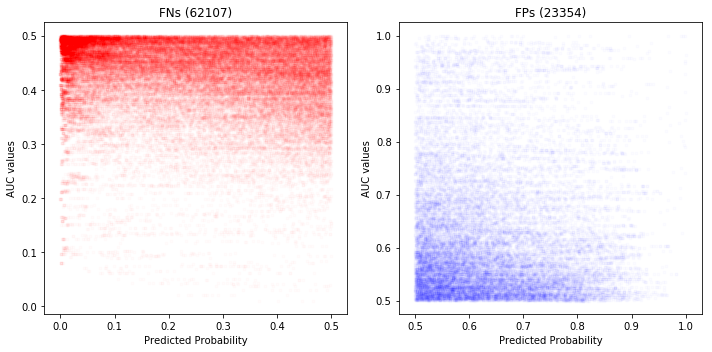

In [23]:
col = 'prd_cat'

figsize=(10,5)
_, ax = plt.subplots(1, 2, figsize=figsize)
ax = ax.ravel()

fn_df = prd_te_all[prd_te_all[col]=='FN']
ax[0].plot(fn_df.y_pred_prob, fn_df.AUC, '.', color='r', alpha=0.01)
ax[0].set_title('FNs ({})'.format( fn_df.shape[0] ))
ax[0].set_xlabel('Predicted Probability');
ax[0].set_ylabel('AUC values')
ax[0].set_xlim(left=-0.03, right=0.53)

fp_df = prd_te_all[prd_te_all[col]=='FP']
ax[1].plot(fp_df.y_pred_prob, fp_df.AUC, '.', color='b', alpha=0.01)
ax[1].set_title('FPs ({})'.format( fp_df.shape[0] ))
ax[1].set_xlabel('Predicted Probability');
ax[1].set_ylabel('AUC values')
ax[1].set_xlim(left=0.47, right=1.03)

plt.tight_layout()
plt.savefig(out_postproc_fpath/'FNs_FPs_Prob_vs_AUC_all.png', dpi=150)

In [49]:
# Drop probs
margin_drop = 0.15
df = prd_te_all[ (prd_te_all.y_pred_prob < margin_drop) | (prd_te_all.y_pred_prob > 1-margin_drop) ]

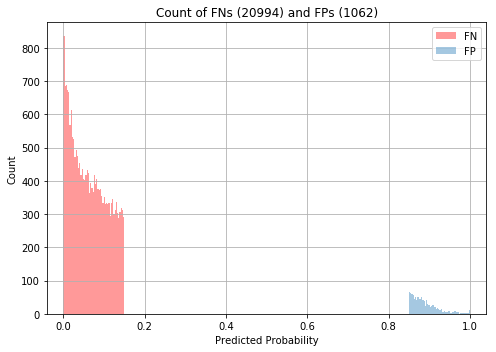

In [50]:
figsize=(7,5)
_, ax = plt.subplots(1,1,figsize=figsize)

fn_df = df[df.prd_cat=='FN']
fp_df = df[df.prd_cat=='FP']

ax = sns.distplot(fn_df.y_pred_prob, bins=50, kde=False, ax=ax, color='r', label='FN');
ax = sns.distplot(fp_df.y_pred_prob, bins=50, kde=False, ax=ax, label='FP');
ax.set_title('Count of FNs ({}) and FPs ({})'.format( fn_df.shape[0], fp_df.shape[0] ))
ax.set_ylabel('Count');
ax.set_xlabel('Predicted Probability');
ax.set_xlim(left=-0.04, right=1.04)
ax.grid(True)
ax.legend();

plt.tight_layout()
plt.savefig(out_postproc_fpath/'FNs_FPs_hist_margin{}.png'.format(margin_drop), dpi=150)

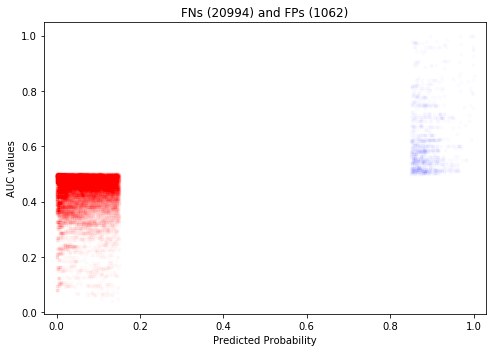

In [51]:
col = 'prd_cat'

figsize=(7,5)
_, ax = plt.subplots(1, 1, figsize=figsize)

fn_df = df[df[col]=='FN']
fp_df = df[df[col]=='FP']
ax.plot(fn_df.y_pred_prob, fn_df.AUC, '.', color='r', alpha=0.01, label='FN')
ax.plot(fp_df.y_pred_prob, fp_df.AUC, '.', color='b', alpha=0.01, label='FP')
ax.set_title('FNs ({}) and FPs ({})'.format( fn_df.shape[0], fp_df.shape[0] ))
ax.set_xlabel('Predicted Probability');
ax.set_ylabel('AUC values')
ax.set_xlim(left=-0.03, right=1.03)
# ax.legend()

plt.tight_layout()
plt.savefig(out_postproc_fpath/'FNs_FPs_Prob_vs_AUC_{}_single_plot.png'.format(margin_drop), dpi=150)

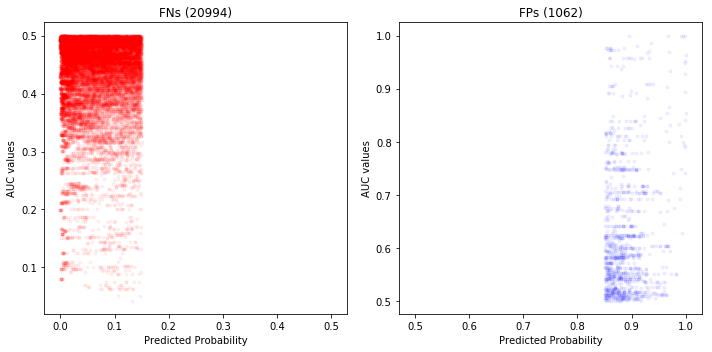

In [52]:
col = 'prd_cat'

figsize=(10,5)
_, ax = plt.subplots(1, 2, figsize=figsize)
ax = ax.ravel()

fn_df = df[df[col]=='FN']
ax[0].plot(fn_df.y_pred_prob, fn_df.AUC, '.', color='r', alpha=0.05)
ax[0].set_title('FNs ({})'.format( fn_df.shape[0] ))
ax[0].set_xlabel('Predicted Probability');
ax[0].set_ylabel('AUC values')
ax[0].set_xlim(left=-0.03, right=0.53)

fp_df = df[df[col]=='FP']
ax[1].plot(fp_df.y_pred_prob, fp_df.AUC, '.', color='b', alpha=0.05)
ax[1].set_title('FPs ({})'.format( fp_df.shape[0] ))
ax[1].set_xlabel('Predicted Probability');
ax[1].set_ylabel('AUC values')
ax[1].set_xlim(left=0.47, right=1.03)

plt.tight_layout()
plt.savefig(out_postproc_fpath/'FNs_FPs_Prob_vs_AUC_{}.png'.format(margin_drop), dpi=150)

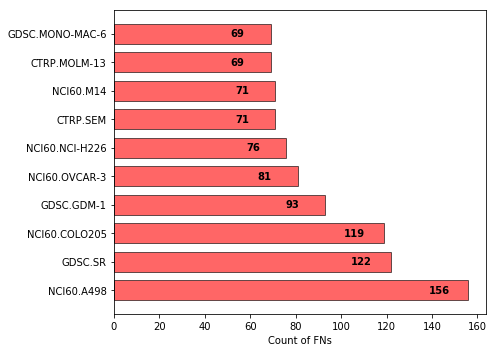

In [36]:
dff = fn_df.groupby('CELL').agg({'idx': len}).sort_values('idx', ascending=False).reset_index()
fig, ax = my_barplot(labels=dff['CELL'].values[:10],
                     values=dff['idx'].values[:10],
                     xlabel='Count of FNs', color='r', figsize=(7,5));
plt.tight_layout()
plt.savefig(out_postproc_fpath/'FNs_barplot_{}.png'.format(margin_drop), dpi=150)

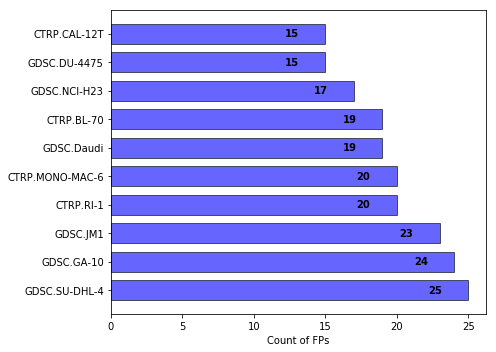

In [37]:
dff = fp_df.groupby('CELL').agg({'idx': len}).sort_values('idx', ascending=False).reset_index()
fig, ax = my_barplot(labels=dff['CELL'].values[:10],
                     values=dff['idx'].values[:10],
                     xlabel='Count of FPs', color='b', figsize=(7,5));
plt.tight_layout()
plt.savefig(out_postproc_fpath/'FPs_barplot_{}.png'.format(margin_drop), dpi=150)

# Create summary table

In [38]:
# Summary table
prd_te_to_grp = prd_te_all.copy()
prd_te_to_grp['y_pred_prob_median'] = prd_te_to_grp.y_pred_prob
prd_te_to_grp['y_pred_prob_std'] = prd_te_to_grp.y_pred_prob
prd_te_to_grp['y_pred_tot'] = prd_te_to_grp.idx
prd_te_to_grp['y_pred_cls_0'] = prd_te_to_grp.y_pred_cls.map(lambda x: True if x==0 else False)
prd_te_to_grp['y_pred_cls_1'] = prd_te_to_grp.y_pred_cls.map(lambda x: True if x==1 else False)
prd_te_to_grp['y_true_unq_vals'] = prd_te_to_grp.y_true_cls

# Cell-wise analysis

In [39]:
def add_conf_data(data):
    """ Add columns are used to calc confusion matrix TP, TN, FN, FP. """
    data['TP'] = data.apply(lambda row: row.y_pred_cls_1 if row.y_true_cls==1 else False, axis=1)  # tp
    data['TN'] = data.apply(lambda row: row.y_pred_cls_0 if row.y_true_cls==0 else False, axis=1)  # tn
    data['FN'] = data.apply(lambda row: row.y_pred_cls_0 if row.y_true_cls==1 else False, axis=1)  # fn
    data['FP'] = data.apply(lambda row: row.y_pred_cls_1 if row.y_true_cls==0 else False, axis=1)  # fp
    
    data['TPR'] = data.apply(lambda row: np.nan if (row.TP==0) & (row.FN==0) else row.TP / (row.TP + row.FN), axis=1)  # sensitivity, recall: TP/P = TP/(TP+FN)
    data['TNR'] = data.apply(lambda row: np.nan if (row.TN==0) & (row.FP==0) else row.TN / (row.TN + row.FP), axis=1)  # specificity: TN/N = TN/(TN+FP)
    
    data['FPR'] = data.apply(lambda row: np.nan if (row.TN==0) & (row.FP==0) else row.FP / (row.TN + row.FP), axis=1)  # fall-out: FP/N = FP/(FP+TN)
    data['FNR'] = data.apply(lambda row: np.nan if (row.TP==0) & (row.FN==0) else row.FN / (row.TP + row.FN), axis=1)  # miss-rate: FN/NP = FN/(FN+TP)
    return data

In [40]:
n_show = 4
cols = ['CTYPE', 'CELL', 'DRUG', 'y_pred_prob_median', 'y_pred_tot', 'TP', 'TN', 'FN', 'FP', 'TPR', 'TNR', 'FPR', 'FNR']
def print_sorted_grouped_df(df, cols, n_show=4):
    print('\nSorted by FN and FNR')
    display( df[cols].sort_values(['FN', 'FNR'], ascending=False)[:n_show].reset_index(drop=True) )

    print('\nSorted by FN and Total Preds')
    display( df[cols].sort_values(['FNR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )

    print('\nSorted by FP and FPR')
    display( df[cols].sort_values(['FP', 'FPR'], ascending=False)[:n_show].reset_index(drop=True) )

    print('\nSorted by FP and Total Preds')
    display( df[cols].sort_values(['FPR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )

In [41]:
# Groupby sample (cell)
by = 'CELL'
sm_cell = prd_te_to_grp.groupby([by, 'y_true_cls']).agg(    
    {'DRUG': 'unique',
     'CTYPE': 'unique',
     'y_true_unq_vals': 'unique',
     'y_pred_prob_median': np.median,
     'y_pred_prob_std': np.std,
     'y_pred_cls_0': lambda x: int(sum(x)),
     'y_pred_cls_1': lambda x: int(sum(x)),
     'y_pred_tot': lambda x: len(np.unique(x)),
     }).reset_index().sort_values(by, ascending=True)

sm_cell['y_true_unq_vals'] = sm_cell.y_true_unq_vals.map(lambda x: len(x) if type(x)==np.ndarray else 1)
sm_cell = add_conf_data(sm_cell)

In [42]:
n_show = 4
cols = ['CTYPE', 'CELL', 'DRUG', 'y_pred_prob_median', 'y_pred_tot', 'TP', 'TN', 'FN', 'FP', 'TPR', 'TNR', 'FPR', 'FNR']
print('\nSorted by FN and FNR')
display( sm_cell[cols].sort_values(['FN', 'FNR'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FN and FNR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,[Kidney_Renal_Clear_Cell_Carcinoma],NCI60.A498,"[NSC.771751, NSC.784815, NSC.762521, NSC.75577...",0.159765,327,63,False,264,False,0.192661,NaN,NaN,0.807339
1,[Lymphoid_Leukemia],GDSC.SR,"[GDSC.273, GDSC.182, GDSC.1007, GDSC.299, GDSC...",0.285866,300,106,False,194,False,0.353333,NaN,NaN,0.646667
2,[Lymphoid_Leukemia],CTRP.SEM,"[CTRP.441, CTRP.247, CTRP.10, CTRP.299, CTRP.3...",0.604302,429,240,False,189,False,0.559441,NaN,NaN,0.440559
3,[Colon_Adenocarcinoma],NCI60.COLO205,"[NSC.747973, NSC.761691, NSC.757149, NSC.75598...",0.117694,225,63,False,162,False,0.280000,NaN,NaN,0.720000


In [43]:
print('\nSorted by FNR and Total Preds')
display( sm_cell[cols].sort_values(['FNR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FNR and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,[Breast_Invasive_Carcinoma],CTRP.HCC2218,"[CTRP.184, CTRP.386, CTRP.307]",0.006816,32,0,False,32,False,0.0,NaN,NaN,1.0
1,[Lung_Adenocarcinoma],GDSC.NCI-H2405,"[GDSC.194, GDSC.200, GDSC.180]",0.344507,31,0,False,31,False,0.0,NaN,NaN,1.0
2,[Kidney_Renal_Clear_Cell_Carcinoma],NCI60.TK-10,"[NSC.700893, NSC.764334, NSC.773095]",0.125553,31,0,False,31,False,0.0,NaN,NaN,1.0
3,[Lung_Adenocarcinoma],CTRP.NCI-H1755,"[CTRP.213, CTRP.203, CTRP.519, CTRP.413]",0.045387,30,0,False,30,False,0.0,NaN,NaN,1.0


In [44]:
print('\nSorted by FP and FPR')
display( sm_cell[cols].sort_values(['FP', 'FPR'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FP and FPR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,[Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma],GDSC.GRANTA-519,"[GDSC.291, GDSC.1161, GDSC.1024, GDSC.151, GDS...",0.007424,937,False,826,False,111,NaN,0.881537,0.118463,NaN
1,[Lymphoid_Leukemia],CTRP.BL-70,"[CTRP.416, CTRP.331, CTRP.404, CTRP.116, CTRP....",0.006641,2407,False,2302,False,105,NaN,0.956377,0.043623,NaN
2,[Lymphoid_Leukemia],CTRP.SEM,"[CTRP.270, CTRP.448, CTRP.514, CTRP.190, CTRP....",0.008303,2708,False,2613,False,95,NaN,0.964919,0.035081,NaN
3,[Kidney_Renal_Clear_Cell_Carcinoma],NCI60.A498,"[NSC.765262, NSC.17777, NSC.754364, NSC.755767...",0.004314,6838,False,6751,False,87,NaN,0.987277,0.012723,NaN


In [45]:
print('\nSorted by FP and Total Preds')
display( sm_cell[cols].sort_values(['FPR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FP and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,[Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma],gCSI.SU-DHL-10,[gCSI.15],0.876694,14,False,0,False,14,NaN,0.0,1.0,NaN
1,[Glioblastoma_Multiforme],gCSI.LN-18,[gCSI.13],0.640766,12,False,0,False,12,NaN,0.0,1.0,NaN
2,[Colon_Adenocarcinoma],gCSI.HCT-116,[gCSI.4],0.654033,10,False,0,False,10,NaN,0.0,1.0,NaN
3,[Lymphoid_Leukemia],gCSI.KE-97,[gCSI.15],0.893602,9,False,0,False,9,NaN,0.0,1.0,NaN


# Cancer-wise analysis

In [61]:
# Groupby Cancer type
by = 'CTYPE'
sm_ctype = prd_te_to_grp.groupby([by, 'y_true_cls']).agg(    
    {'DRUG': 'unique',
     'CELL': 'unique',
     'y_true_unq_vals': 'unique',
     'y_pred_prob_median': np.median,
     'y_pred_prob_std': np.std,
     'y_pred_cls_0': lambda x: int(sum(x)),
     'y_pred_cls_1': lambda x: int(sum(x)),
     'y_pred_tot': lambda x: len(np.unique(x)),
     }).reset_index().sort_values(by, ascending=True)

sm_ctype['y_true_unq_vals'] = sm_ctype.y_true_unq_vals.map(lambda x: len(x) if type(x)==np.ndarray else 1)
sm_ctype = add_conf_data(sm_ctype)
# display(sm_ctype[:2])

In [62]:
# Print sorted
# print_sorted_grouped_df(sm_ctype, cols=cols, n_show=2)

In [63]:
n_show = 2
cols = ['CTYPE', 'CELL', 'DRUG', 'y_pred_prob_median', 'y_pred_tot', 'TP', 'TN', 'FN', 'FP', 'TPR', 'TNR', 'FPR', 'FNR']
print('\nSorted by FN and FNR')
display( sm_ctype[cols].sort_values(['FN', 'FNR'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FN and FNR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Lymphoid_Leukemia,"[CTRP.P3HR-1, CTRP.SR-786, GDSC.BL-41, CTRP.Ra...","[CTRP.254, CTRP.221, CTRP.165, CTRP.43, CTRP.1...",0.699162,15025,10149,False,4876,False,0.675474,NaN,NaN,0.324526
1,Lung_Adenocarcinoma,"[GDSC.HCC-78, CTRP.A549, CTRP.NCI-H2405, NCI60...","[GDSC.200, GDSC.283, CTRP.235, CTRP.542, CTRP....",0.499760,7032,3512,False,3520,False,0.499431,NaN,NaN,0.500569


In [64]:
print('\nSorted by FN and Total Preds')
display( sm_ctype[cols].sort_values(['FNR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FN and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Kidney_Renal_Clear_Cell_Carcinoma,"[CTRP.VMRC-RCZ, GDSC.RXF393, CTRP.BFTC-909, NC...","[CTRP.157, CTRP.542, GDSC.51, GDSC.283, GDSC.2...",0.310184,2271,563,False,1708,False,0.247908,NaN,NaN,0.752092
1,Ovarian_Serous_Cystadenocarcinoma,"[CTRP.IGROV-1, NCI60.OVCAR-5, CTRP.OV7, NCI60....","[CTRP.3, CTRP.157, NSC.771751, NSC.747973, CTR...",0.411082,2568,1009,False,1559,False,0.392913,NaN,NaN,0.607087


In [65]:
print('\nSorted by FP and FPR')
display( sm_ctype[cols].sort_values(['FP', 'FPR'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FP and FPR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Lymphoid_Leukemia,"[CTRP.P3HR-1, CTRP.SR-786, GDSC.BL-41, CTRP.Ra...","[CTRP.126, CTRP.360, CTRP.92, CTRP.236, CTRP.5...",0.004428,151673,False,149054,False,2619,NaN,0.982733,0.017267,NaN
1,Colon_Adenocarcinoma,"[NCI60.KM12, NCI60.HCC-2998, CTRP.HCT-15, CTRP...","[NSC.781009, NSC.765395, NSC.207895, NSC.76008...",0.002020,159865,False,158307,False,1558,NaN,0.990254,0.009746,NaN


In [66]:
print('\nSorted by FP and Total Preds')
display( sm_ctype[cols].sort_values(['FPR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FP and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,"[CTRP.JM1, CTRP.A3-KAW, GDSC.A4-Fuk, GDSC.SU-D...","[CTRP.201, CTRP.53, CTRP.92, CTRP.339, CTRP.44...",0.005823,61040,False,59700,False,1340,NaN,0.978047,0.021953,NaN
1,Acute_Myeloid_Leukemia,"[CTRP.MOLM-13, GDSC.ME-1, GDSC.GDM-1, CTRP.HEL...","[CTRP.1, CTRP.172, CTRP.430, CTRP.337, CTRP.23...",0.005104,61091,False,59837,False,1254,NaN,0.979473,0.020527,NaN


# Drug-wise analysis

In [67]:
# Groupby Drug
by = 'DRUG'
sm_drug = prd_te_to_grp.groupby([by, 'y_true_cls']).agg(    
    {'CTYPE': 'unique',
     'CELL': 'unique',
     'y_true_unq_vals': 'unique',
     'y_pred_prob_median': np.median,
     'y_pred_prob_std': np.std,
     'y_pred_cls_0': lambda x: int(sum(x)),
     'y_pred_cls_1': lambda x: int(sum(x)),
     'y_pred_tot': lambda x: len(np.unique(x)),
     }).reset_index().sort_values(by, ascending=True)

sm_drug['y_true_unq_vals'] = sm_drug.y_true_unq_vals.map(lambda x: len(x) if type(x)==np.ndarray else 1)
sm_drug = add_conf_data(sm_drug)
# display(sm_drug[:2])

In [68]:
# Print sorted
# print_sorted_grouped_df(sm_drug, cols=cols, n_show=2)

In [69]:
n_show = 2
cols = ['CTYPE', 'CELL', 'DRUG', 'y_pred_prob_median', 'y_pred_tot', 'TP', 'TN', 'FN', 'FP', 'TPR', 'TNR', 'FPR', 'FNR']
print('\nSorted by FN and FNR')
display( sm_drug[cols].sort_values(['FN', 'FNR'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FN and FNR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Liver_Hepatocellular_Carcinoma, Lymphoid_Leuk...","[CTRP.SNU-423, CTRP.P3HR-1, CTRP.HEC-1-A, CTRP...",CTRP.3,0.407958,2033,857,False,1176,False,0.421545,NaN,NaN,0.578455
1,"[Lung_Adenocarcinoma, Lymphoid_Leukemia, Lymph...","[GDSC.HCC-78, GDSC.BL-41, GDSC.SU-DHL-4, GDSC....",GDSC.283,0.438964,1914,767,False,1147,False,0.400731,NaN,NaN,0.599269


In [70]:
print('\nSorted by FN and Total Preds')
display( sm_drug[cols].sort_values(['FNR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FN and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Lung_Non-Small_Cell_Carcinoma, Head_and_Neck_...","[GDSC.NCI-H647, GDSC.HSC-3, GDSC.LOU-NH91, GDS...",GDSC.190,0.019538,141,0,False,141,False,0.0,NaN,NaN,1.0
1,"[Stomach_Adenocarcinoma, Lymphoid_Neoplasm_Dif...","[CTRP.SNU-16, CTRP.JM1, CTRP.NALM-6, CTRP.A4-F...",CTRP.31,0.113286,120,0,False,120,False,0.0,NaN,NaN,1.0


In [71]:
print('\nSorted by FP and FPR')
display( sm_drug[cols].sort_values(['FP', 'FPR'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FP and FPR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Lung_Non-Small_Cell_Carcinoma, Acute_Myeloid_...","[GDSC.NCI-H1581, GDSC.ME-1, GDSC.MDA-MB-134-VI...",GDSC.200,0.568605,1594,False,571,False,1023,NaN,0.358218,0.641782,NaN
1,"[Stomach_Adenocarcinoma, Lung_Squamous_Cell_Ca...","[CTRP.MKN45, CTRP.EPLC-272H, CTRP.U-118-MG, CT...",CTRP.542,0.662708,1191,False,190,False,1001,NaN,0.159530,0.840470,NaN


In [72]:
print('\nSorted by FP and Total Preds')
display( sm_drug[cols].sort_values(['FPR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FP and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Colon_Adenocarcinoma, Esophageal_Carcinoma, L...","[gCSI.COLO-678, gCSI.KYSE-140, gCSI.HUH-7, gCS...",gCSI.2,0.808105,192,False,1,False,191,NaN,0.005208,0.994792,NaN
1,"[Skin_Cutaneous_Melanoma, Lung_Adenocarcinoma,...","[CTRP.SK-MEL-28, CTRP.A549, CTRP.NCI-H196, CTR...",CTRP.157,0.793931,577,False,6,False,571,NaN,0.010399,0.989601,NaN


# Sample-wise Analysis

In [88]:
# Groupby sample (cell-drug)
sm = prd_te_to_grp.groupby(['CELL', 'DRUG']).agg(
    {'CTYPE': np.unique,
     'y_true_cls': np.unique,
     'y_true_unq_vals': np.unique,
     'y_pred_prob_median': np.median,
     'y_pred_prob_std': np.std,
     'y_pred_cls_0': lambda x: int(sum(x)),
     'y_pred_cls_1': lambda x: int(sum(x)),
     }).reset_index()
sm['y_true_unq_vals'] = sm.y_true_unq_vals.map(lambda x: len(x) if type(x)==np.ndarray else 1)
# display(sm[:2])

## Most confident predictions of responders

In [89]:
# Most confident predictions of responders
n_show = 2
rsp_value = 1  # responders
aa = sm[sm.y_true_cls==rsp_value]

print('\nMost confident TPs (correct predictions of responders)')
aa_ = aa.sort_values('y_pred_prob_median', ascending=False)
display(aa_[:n_show].reset_index(drop=True))

print('\nMost confident FNs (incorrect predictions of responders)')
aa_ = aa.sort_values('y_pred_prob_median', ascending=True)
display(aa_[:n_show].reset_index(drop=True))


Most confident TPs (correct predictions of responders)


,CELL,DRUG,CTYPE,y_true_cls,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,GDSC.697,GDSC.104,Lymphoid_Leukemia,1,1,0.977313,0.003974,0,9
1,CTRP.GA-10,CTRP.157,Lymphoid_Leukemia,1,1,0.976653,0.003820,0,3



Most confident FNs (incorrect predictions of responders)


,CELL,DRUG,CTYPE,y_true_cls,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,GDSC.NCI-H209,GDSC.1005,Lung_Small_Cell_Carcinoma,1,1,0.000041,0.000026,8,0
1,CTRP.DOHH-2,CTRP.425,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,1,1,0.000248,0.000102,8,0


## Most confident predictions of non-responders

In [90]:
# Most confident predictions of non-responders
n_show = 2
rsp_value = 0  # non-responders
bb = sm[sm.y_true_cls==rsp_value]

print('\nMost confident TNs (correct predictions of non-responders)')
bb_ = bb.sort_values('y_pred_prob_median', ascending=True)
display(bb_[:n_show].reset_index(drop=True))

print('\nMost confident FPs (incorrect predictions of non-responders)')
bb_ = bb.sort_values('y_pred_prob_median', ascending=False)
display(bb_[:n_show].reset_index(drop=True))


Most confident TNs (correct predictions of non-responders)


,CELL,DRUG,CTYPE,y_true_cls,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,NCI60.IGR-OV1,NSC.752,Ovarian_Serous_Cystadenocarcinoma,0,1,0.000024,0.000012,10,0
1,NCI60.SW-620,NSC.752,Colon_Adenocarcinoma,0,1,0.000026,0.000015,6,0



Most confident FPs (incorrect predictions of non-responders)


,CELL,DRUG,CTYPE,y_true_cls,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,GDSC.GA-10,GDSC.1004,Lymphoid_Leukemia,0,1,0.959442,0.009857,0,11
1,GDSC.DOHH-2,GDSC.60,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,0,1,0.934460,0.013085,0,11


## Least confident True Positives

In [91]:
# Least confident predictions of responders
n_show = 2
rsp_value = 1  # responders
aa = sm[sm.y_true_cls==rsp_value]

# Extract samples with probs >= 0.5
aa = aa[aa.y_pred_prob_median-0.5 >= 0]

print('\nLeast confident TPs (correct predictions of responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=True)
display(aa[:n_show].reset_index(drop=True))


Least confident TPs (correct predictions of responders)


,CELL,DRUG,CTYPE,y_true_cls,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,CCLE.SKLMS1,CCLE.11,Sarcoma,1,1,0.500174,0.038317,6,7
1,GDSC.OCUM-1,GDSC.1372,Stomach_Adenocarcinoma,1,1,0.500290,0.154979,4,5


## Least confident False Positives

In [85]:
# Least confident predictions of non-responders
n_show = 2
rsp_value = 0  # non-responders
aa = sm[sm.y_true_cls==rsp_value]

# Extract samples with probs >= 0.5
aa = aa[aa.y_pred_prob_median-0.5 >= 0]

print('\nLeast confident FPs (incorrect predictions of non-responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=True)
display(aa[:n_show].reset_index(drop=True))


Least confident FPs (incorrect predictions of non-responders)


,CELL,DRUG,CTYPE,y_true_cls,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,CTRP.NCI-H2029,CTRP.542,Lung_Small_Cell_Carcinoma,0,1,0.500314,0.090629,5,6
1,GDSC.CW-2,GDSC.268,Colon_Adenocarcinoma,0,1,0.500364,0.053807,5,5


## Least confident False Negatives

In [86]:
# Least confident predictions of responders
n_show = 2
rsp_value = 1  # responders
aa = sm[sm.y_true_cls==rsp_value]

# Extract samples with probs <= 0.5
aa = aa[aa.y_pred_prob_median-0.5 <= 0]

print('\nLeast confident FNs (incorrect predictions of responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=False)
display(aa[:n_show].reset_index(drop=True))


Least confident FNs (incorrect predictions of responders)


,CELL,DRUG,CTYPE,y_true_cls,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,CTRP.BICR-18,CTRP.519,Head_and_Neck_Squamous_Cell_Carcinoma,1,1,0.499633,0.046791,5,4
1,CCLE.ZR751,CCLE.11,Breast_Invasive_Carcinoma,1,1,0.499590,0.080635,6,6


## Least confident True Negatives

In [87]:
# Least confident predictions of non-responders
n_show = 2
rsp_value = 0  # non-responders
aa = sm[sm.y_true_cls==rsp_value]

# Extract samples with probs <= 0.5
aa = aa[aa.y_pred_prob_median-0.5 <= 0]

print('\nLeast confident TNs (correct predictions of non-responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=False)
display(aa[:n_show].reset_index(drop=True))


Least confident TNs (correct predictions of non-responders)


,CELL,DRUG,CTYPE,y_true_cls,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,GDSC.KP-2,GDSC.1004,Pancreatic_Adenocarcinoma,0,1,0.499918,0.049157,4,3
1,NCI60.HCT-116,NSC.760087,Colon_Adenocarcinoma,0,1,0.499827,0.058512,8,7
